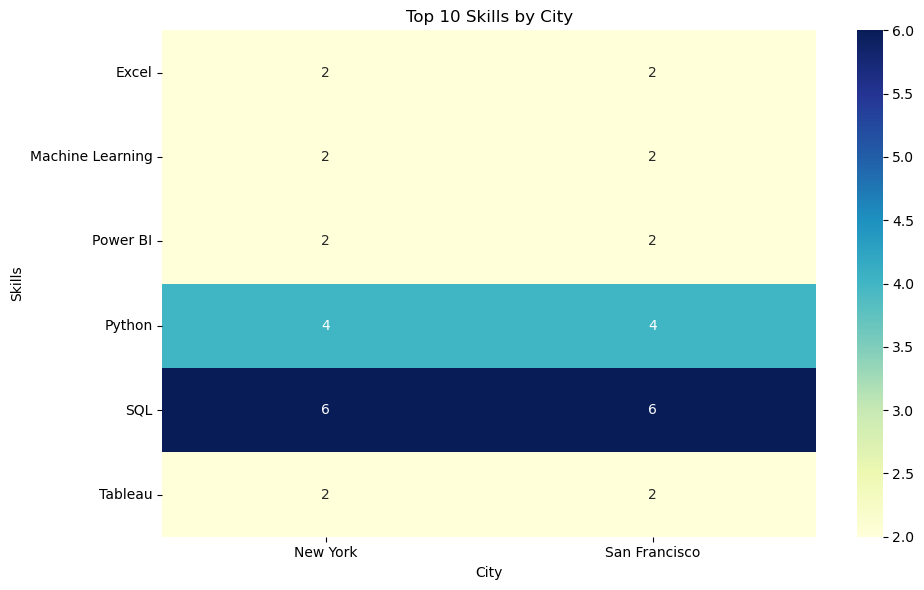

✅ Analysis complete! Files saved.


In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Simulated list of roles and cities
roles = ['Data Analyst', 'Data Scientist']
cities = ['New York', 'San Francisco']

# Placeholder to store scraped data
job_data = []

# Simulated function to mimic scraping (replace with actual logic using Selenium for LinkedIn)
def scrape_jobs(role, city):
    # Simulated data
    return [
        {'title': f'{role} - Entry Level', 'location': city, 'skills': ['Python', 'Excel', 'SQL']},
        {'title': f'{role} - Mid Level', 'location': city, 'skills': ['SQL', 'Tableau', 'Power BI']},
        {'title': f'{role} - Senior', 'location': city, 'skills': ['Python', 'Machine Learning', 'SQL']}
    ]

# Scrape simulated data
for role in roles:
    for city in cities:
        jobs = scrape_jobs(role, city)
        for job in jobs:
            job_data.append({'Role': role, 'City': city, 'Title': job['title'], 'Skills': job['skills']})

# Convert to DataFrame
df = pd.DataFrame(job_data)

# Explode skills column to count skills individually
df_exploded = df.explode('Skills')

# Count top 10 skills per city
top_skills_by_city = df_exploded.groupby(['City', 'Skills']).size().reset_index(name='Count')
top_skills_by_city = top_skills_by_city.sort_values(['City', 'Count'], ascending=[True, False])
top_skills_by_city = top_skills_by_city.groupby('City').head(10)

# Pivot table for heatmap
pivot = top_skills_by_city.pivot(index='Skills', columns='City', values='Count').fillna(0)

# 📊 Heatmap: Top 10 Skills by City
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap='YlGnBu')
plt.title('Top 10 Skills by City')
plt.ylabel('Skills')
plt.xlabel('City')
plt.tight_layout()
plt.show()

# Skill vs Role Matrix
skill_vs_role = df_exploded.groupby(['Role', 'Skills']).size().unstack(fill_value=0)

# Save outputs
df.to_excel('job_postings.xlsx', index=False)
pivot.to_excel('heatmap_data.xlsx')
skill_vs_role.to_excel('skill_vs_role_matrix.xlsx')

print("✅ Analysis complete! Files saved.")

In [15]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.parse

# -------------------------
# USER INPUT
# -------------------------
job_title = input("Enter job title: ").strip()
location = input("Enter location: ").strip()

# Fix typos & format query
job_title_query = urllib.parse.quote_plus(job_title)
location_query = urllib.parse.quote_plus(location)

# -------------------------
# SETUP SELENIUM
# -------------------------
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--window-size=1920,1080")

driver = webdriver.Chrome(options=options)

# LinkedIn job search URL
search_url = f"https://www.linkedin.com/jobs/search?keywords={job_title_query}&location={location_query}"
driver.get(search_url)

# Wait for job cards to load
try:
    WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CLASS_NAME, "base-card"))
    )
except:
    print("Timed out waiting for job cards to load.")

# Scroll to load more jobs
for _ in range(3):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)

# -------------------------
# PARSE PAGE CONTENT
# -------------------------
soup = BeautifulSoup(driver.page_source, "html.parser")
job_cards = soup.find_all("li", class_="jobs-search-results__list-item")

print(f"Found {len(job_cards)} job cards.")

jobs_data = []

for card in job_cards:
    try:
        title_tag = card.find("h3", class_="base-search-card__title")
        company_tag = card.find("h4", class_="base-search-card__subtitle")
        location_tag = card.find("span", class_="job-search-card__location")
        link_tag = card.find("a", class_="base-card__full-link")

        title = title_tag.get_text(strip=True) if title_tag else ""
        company = company_tag.get_text(strip=True) if company_tag else ""
        loc = location_tag.get_text(strip=True) if location_tag else ""
        link = link_tag['href'] if link_tag else ""

        if title:  # Skip empty entries
            jobs_data.append({"Title": title, "Company": company, "Location": loc, "Link": link})
    except Exception as e:
        print("Error parsing a job card:", e)
        continue

driver.quit()

# -------------------------
# CREATE DATAFRAME
# -------------------------
df = pd.DataFrame(jobs_data)
print("DataFrame created with columns:", df.columns.tolist())
print(df.head())

# -------------------------
# MOCK SKILL EXTRACTION FROM TITLES
# -------------------------
skill_keywords = ['Python', 'Excel', 'SQL', 'Tableau', 'Power BI', 'Machine Learning', 
                  'Communication', 'Leadership', 'AWS', 'Data Analysis']

if 'Title' in df.columns and not df.empty:
    df['Skills'] = df['Title'].apply(lambda title: [skill for skill in skill_keywords if skill.lower() in title.lower()])
else:
    df['Skills'] = []

# -------------------------
# GENERATE HEATMAP
# -------------------------
if not df.empty and df['Skills'].notna().any():
    df_exploded = df.explode('Skills').dropna()
    heatmap_data = df_exploded.groupby(['Location', 'Skills']).size().unstack(fill_value=0)

    # Filter to top 10 skills
    top_skills = heatmap_data.sum().sort_values(ascending=False).head(10).index
    heatmap_data = heatmap_data[top_skills]

    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt='d')
    plt.title(f"Top 10 Skill Demand by Location for '{job_title}'")
    plt.ylabel("City")
    plt.xlabel("Skill")
    plt.tight_layout()
    plt.savefig("skill_heatmap.png")
    plt.show()
    print("Heatmap saved as 'skill_heatmap.png'.")
else:
    print("No skills found to generate heatmap.")

# -------------------------
# SAVE TO EXCEL
# -------------------------
df.to_excel("linkedin_jobs.xlsx", index=False)
print("Job data saved to 'linkedin_jobs.xlsx'.")


Enter job title:  data analyst
Enter location:  india


Found 0 job cards.
DataFrame created with columns: []
Empty DataFrame
Columns: []
Index: []
No skills found to generate heatmap.
Job data saved to 'linkedin_jobs.xlsx'.
